# Another image classifier using CNN 

Competition link: https://www.kaggle.com/c/plant-seedlings-classification

The objective and data set organization is similar to the Dog/Cat classification and the Flower Recognition, so I'll use the same approach with resnet34 model.

## Data input & visualization 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
path = "data/seedlings/"

In [5]:
os.listdir(path)

['models', 'sample_submission.csv', 'test', 'tmp', 'train', 'val']

In [6]:
sample = os.listdir(path+'train/Fat Hen/')[:5]; sample

['00268e97d.png',
 '009004da3.png',
 '01396e759.png',
 '01437202b.png',
 '0157c4199.png']

In [7]:
img = plt.imread(path+'train/Fat Hen/'+sample[4])

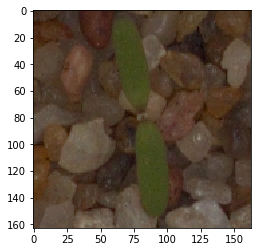

In [8]:
plt.imshow(img)

In [9]:
img.shape

(163, 163, 3)

Image size is quite small compared to regular images on ImageNet. Don't really know how it will affect the performance of my model


Split data set into training & validation sets

From the files in the data set, manually select 20% of the data and put it in the validation set.

## Train model 

In [5]:
arch = resnet34
sz = 224

In [6]:
data = ImageClassifierData.from_paths(path, trn_name='train', val_name='val', test_name='test', tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(0.01, 3)

In [7]:
lrf=learn.lr_find()

 85%|██████████████████████████████████████████████████████████████           | 51/60 [00:03<00:00, 14.20it/s, loss=27]


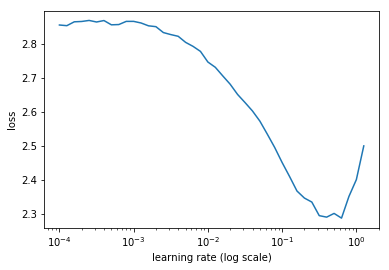

In [8]:
learn.sched.plot()

In [9]:
learn.fit(0.1, 2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.475421   0.964589   0.704211  
    1      1.099059   0.684407   0.768421                                                                              



[array([0.68441]), 0.768421052380612]

In [15]:
lrf=learn.lr_find()

 78%|███████████████████████████████████████████████████████▌               | 47/60 [00:00<00:00, 70.65it/s, loss=2.21]


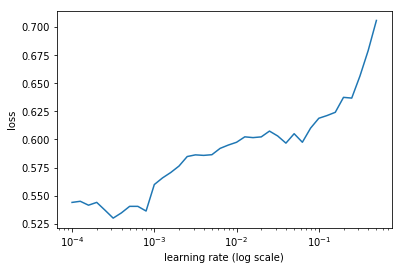

In [16]:
learn.sched.plot()

In [17]:
learn.fit(1e-4, 3)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.606441   0.558172   0.805263  
    1      0.587954   0.555292   0.804211                                                                              
    2      0.582131   0.553942   0.803158                                                                              



[array([0.55394]), 0.8031578951132925]

In [18]:
lrf=learn.lr_find()

 83%|███████████████████████████████████████████████████████████▏           | 50/60 [00:00<00:00, 75.28it/s, loss=2.82]


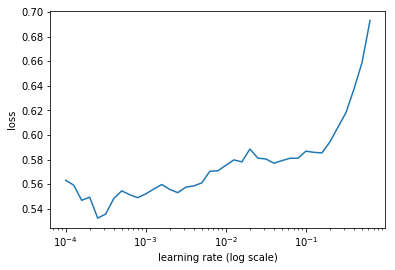

In [19]:
learn.sched.plot()

## Data augmentation 

In [6]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [7]:
data = ImageClassifierData.from_paths(path, trn_name='train', val_name='val', test_name='test', tfms=tfms, bs=32)
learn = ConvLearner.pretrained(arch, data)

In [12]:
learn.fit(1e-1, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.575327   0.950079   0.692632  



[array([0.95008]), 0.6926315805786535]

In [13]:
learn.fit(0.1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.938527   0.603533   0.788421  
    1      0.886189   0.562417   0.804211                                                                              
    2      0.770805   0.540071   0.815789                                                                              



[array([0.54007]), 0.8157894746880783]

In [14]:
learn.save('224_last')

In [8]:
learn.load('224_last')

In [9]:
learn.unfreeze()

In [10]:
lr=np.array([1e-1/9,1e-1/3,1e-1])

In [11]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.998727   0.524979   0.823158  
    1      0.745689   0.646799   0.801053                                                                              
    2      0.441741   0.267811   0.915789                                                                              
    3      0.514014   0.701635   0.785263                                                                              
    4      0.475368   0.596876   0.78                                                                                  
    5      0.309978   0.210408   0.930526                                                                              
    6      0.229868   0.189997   0.935789                                                                              



[array([0.19]), 0.9357894736842105]

In [12]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

## Make prediction & submission file 

In [13]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [14]:
preds = np.argmax(probs, axis=1)

In [20]:
preds[:5]

0    Small-flowered Cranesbill
1                      Fat Hen
2                   Sugar beet
3             Common Chickweed
4                   Sugar beet
dtype: object

In [37]:
preds.shape

(794,)

In [15]:
preds = pd.Series(preds)

In [16]:
preds = preds.apply(lambda x: data.classes[x])

In [17]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

For eachfile in the test set, you must predict a probability for the species variable. The file should contain a header and have the following format:

file,species
0021e90e4.png,Maize
003d61042.png,Sugar beet
007b3da8b.png,Common wheat
etc.

In [18]:
fnames = [names[5:] for names in data.test_ds.fnames]

In [19]:
fnames[:5]

['0021e90e4.png',
 '003d61042.png',
 '007b3da8b.png',
 '0086a6340.png',
 '00c47e980.png']

In [21]:
my_submission = pd.DataFrame({'file': fnames, 'species': preds})

In [22]:
my_submission.head()

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet


In [23]:
my_submission.to_csv('seedlings_submission.csv', index=False)

## Results

Result on the private leaderboard: My score is 0.85390 which is ranked 640ish in the public leaderboard. It seems that the training size is too small, I'll try again with sz = 224 and see if there's any difference.

Second attempt, the score is 0.85768 which is a minor improvement. Good news is the accuracy score on validation set is similar to the test set. I'm still confused about the loss function in the model, will post on fastai forum for help. I need to figure out ways to improve score to 0.9

Third attempt, score is 0.94458. Feel great about my model :D It trains a lot faster (I used a LR = 0.1 for last layer, /3 for previous layers), although I runs only 2 epochs after data augmentation, and 3 more epochs after unfreezing all layers (cycle_mult = 2). I used only 80% of the data set as training data. Validation score is indicative of the test score. 